自动检测到起点：(173, 327), 终点：(173, 21)


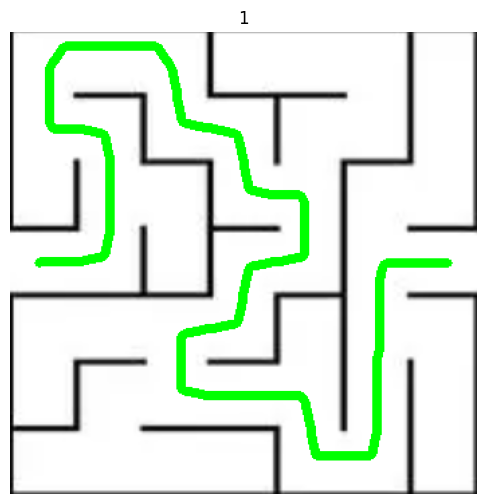

In [6]:


import cv2
import numpy as np
import heapq
import matplotlib.pyplot as plt


def dijkstra_path(binary, start, end, dt):
    h, w = binary.shape
    INF = 1e9
    dist = np.full((h, w), INF, dtype=np.float32)
    dist[start[0], start[1]] = 0.0
    parent = dict()
    pq = []
    heapq.heappush(pq, (0.0, start))

    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while pq:
        cur_cost, (cy, cx) = heapq.heappop(pq)
        if (cy, cx) == end:
            break
        if cur_cost > dist[cy, cx]:
            continue
        for dy, dx in neighbors:
            ny, nx = cy + dy, cx + dx
            if 0 <= ny < h and 0 <= nx < w:
                if binary[ny, nx] == 255:
                    step_cost = 1.0 / (dt[ny, nx] + 1.0)
                    new_cost = cur_cost + step_cost
                    if new_cost < dist[ny, nx]:
                        dist[ny, nx] = new_cost
                        parent[(ny, nx)] = (cy, cx)
                        heapq.heappush(pq, (new_cost, (ny, nx)))

    if dist[end[0], end[1]] == INF:
        return None

    path = []
    cur = end
    while cur != start:
        path.append(cur)
        cur = parent[cur]
    path.append(start)
    path.reverse()
    return path


def smooth_path(path, window_size=5):
    if window_size < 3:
        return path
    half_win = window_size // 2
    smooth_pts = []
    for i in range(len(path)):
        window = path[max(0, i - half_win): min(len(path), i + half_win + 1)]
        avg_r = int(round(sum(pt[0] for pt in window) / len(window)))
        avg_c = int(round(sum(pt[1] for pt in window) / len(window)))
        smooth_pts.append((avg_r, avg_c))
    return smooth_pts

def find_red_points(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([179, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) < 2:
        raise Exception("未找到足够的红色区域作为起点和终点！")

    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    points = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            raise Exception("检测到的红色区域质心无效！")
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        points.append((cy, cx))  # (row, col)

    return points[0], points[1]  # 只返回两个点


def main(image_path=None):
    # 读取图像
    original_img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if original_img is None:
        raise FileNotFoundError("无法读取图像，请检查路径。")

    # 自动找到红色的起点终点
    start_point, end_point = find_red_points(original_img)
    print(f"自动检测到起点：{start_point}, 终点：{end_point}")

    # 提前把红色点替换成白色，确保不会影响路径搜索

    hsv = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([179, 255, 255])
    mask_red = cv2.inRange(hsv, lower_red1, upper_red1) | cv2.inRange(hsv, lower_red2, upper_red2)
    original_img[mask_red > 0] = [255, 255, 255]

    # 转灰度再二值化
    gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 计算距离变换图 dt
    dt = cv2.distanceTransform(binary, cv2.DIST_L2, 3)

    # 检查起点和终点是否位于通路上
    if binary[start_point[0], start_point[1]] != 255:
        print("起点不在通路上，可能导致路径搜索失败。")
    if binary[end_point[0], end_point[1]] != 255:
        print("终点不在通路上，可能导致路径搜索失败。")

    # Dijkstra算法
    path = dijkstra_path(binary, start_point, end_point, dt)
    if path is None:
        raise Exception("未找到路径")

    # 平滑路径并绘制结果
    smoothed_path = smooth_path(path, window_size=7)

    solution_img = original_img.copy()
    pts = np.array([[p[1], p[0]] for p in smoothed_path], np.int32).reshape((-1, 1, 2))
    cv2.polylines(solution_img, [pts], False, (0, 255, 0), thickness=5)

    solution_img_rgb = cv2.cvtColor(solution_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(solution_img_rgb)
    plt.title("1")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main(image_path="1.png")


自动检测到起点：(112, 31), 终点：(111, 469)


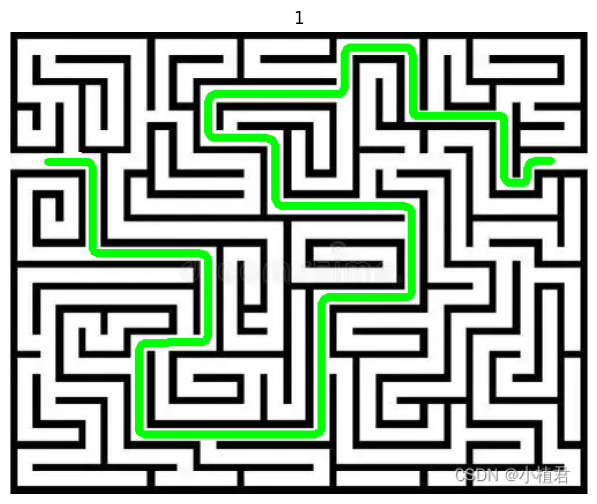

In [7]:
if __name__ == "__main__":
    main(image_path="2.png")

自动检测到起点：(665, 342), 终点：(13, 343)


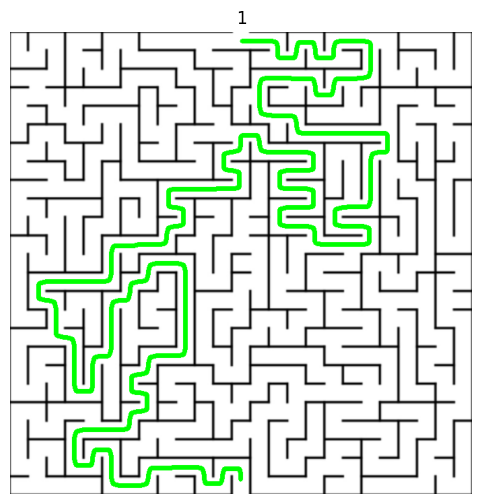

In [8]:
if __name__ == "__main__":
    main(image_path="3.png")

自动检测到起点：(1298, 681), 终点：(13, 660)


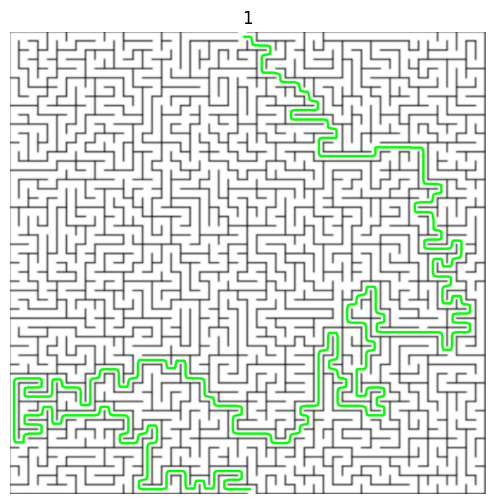

In [9]:
if __name__ == "__main__":
    main(image_path="4.png")

自动检测到起点：(1023, 514), 终点：(2, 513)


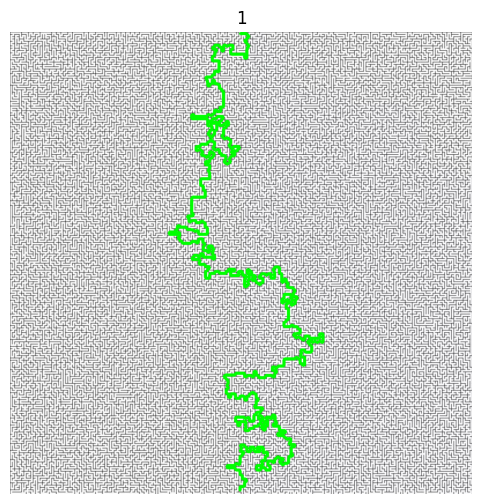

In [19]:
if __name__ == "__main__":
    main(image_path="Puzzle5.png")

自动检测到起点：(1173, 399), 终点：(30, 403)


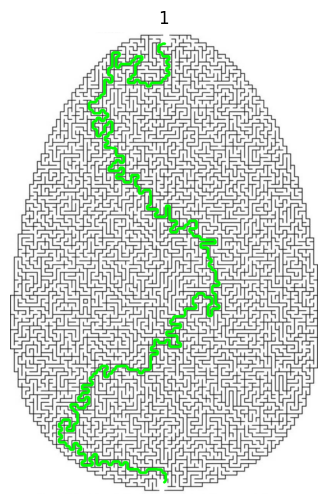

In [16]:
if __name__ == "__main__":
    main(image_path="6.png")

自动检测到起点：(588, 13), 终点：(580, 559)


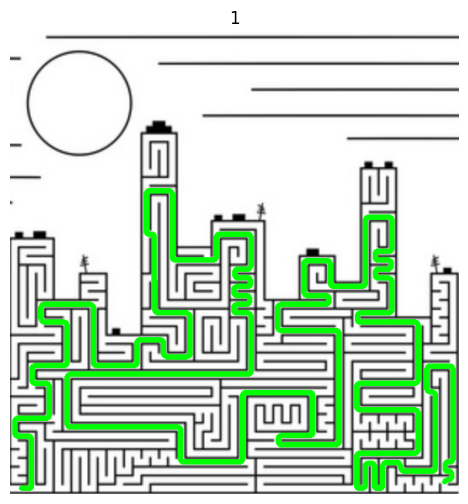

In [17]:
if __name__ == "__main__":
    main(image_path="7.png")

起点: (40, 58)
终点: (679, 496)


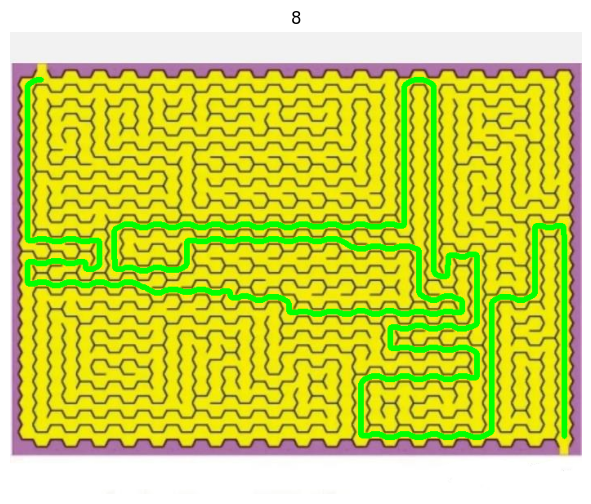

In [29]:
import cv2
import numpy as np
import heapq  # Python内置最小堆，用于实现Dijkstra优先队列

def dijkstra_path(binary, start, end, dt):
    h, w = binary.shape
    INF = 1e9
    dist = np.full((h, w), INF, dtype=np.float32)  # 记录到达每个像素的最小代价
    dist[start[0], start[1]] = 0.0

    parent = dict()  # 用于回溯路径
    pq = []
    heapq.heappush(pq, (0.0, start))

    # 仅4邻域示例，若需要可改8邻域
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while pq:
        cur_cost, (cy, cx) = heapq.heappop(pq)
        if (cy, cx) == end:
            break
        if cur_cost > dist[cy, cx]:
            continue
        for dy, dx in neighbors:
            ny, nx = cy + dy, cx + dx
            if 0 <= ny < h and 0 <= nx < w:
                # 必须在通路上
                if binary[ny, nx] == 255:
                    # cost = 1/(dt[ny, nx] + 1)，离墙越远 dt越大，cost越小
                    step_cost = 1.0 / (dt[ny, nx] + 1.0)
                    new_cost = cur_cost + step_cost
                    if new_cost < dist[ny, nx]:
                        dist[ny, nx] = new_cost
                        parent[(ny, nx)] = (cy, cx)
                        heapq.heappush(pq, (new_cost, (ny, nx)))

    if dist[end[0], end[1]] == INF:
        return None

    # 回溯
    path = []
    cur = end
    while cur != start:
        path.append(cur)
        cur = parent[cur]
    path.append(start)
    path.reverse()
    return path

def smooth_path(path, window_size=5):
    if window_size < 3:
        return path
    half_win = window_size // 2
    smoothed = []
    for i in range(len(path)):
        window = path[max(0, i - half_win): min(len(path), i + half_win + 1)]
        avg_r = int(round(sum(pt[0] for pt in window) / len(window)))
        avg_c = int(round(sum(pt[1] for pt in window) / len(window)))
        smoothed.append((avg_r, avg_c))
    return smoothed

if __name__ == "__main__":
    # ----------------------------
    # 1. 读取彩色图像
    # ----------------------------
    image_path = 'Puzzle8.png'
    original_img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if original_img is None:
        raise FileNotFoundError("无法读取图像，请检查路径。")

    # ----------------------------
    # 2. 提取黄色区域 (通道)
    # ----------------------------
    hsv = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([0, 200, 200])
    upper_yellow = np.array([50, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # 可选形态学操作，去除噪点
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_OPEN, kernel, iterations=1)
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, kernel, iterations=1)

    # ----------------------------
    # 3. 提取黑色线条 (墙)
    # ----------------------------
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([50, 255, 200])
    mask_black = cv2.inRange(hsv, lower_black, upper_black)

    # 如果黑线过细，可以适当膨胀，让墙线更粗
    mask_black = cv2.dilate(mask_black, kernel, iterations=1)

    # ----------------------------
    # 4. 从黄色通道中排除黑线
    # ----------------------------
    # 这样黑线区域就变成0，不可行走
    mask_black_inv = cv2.bitwise_not(mask_black)  # 黑线=0, 非黑线=255
    final_mask = cv2.bitwise_and(mask_yellow, mask_black_inv)# final_mask中 255=通道(黄)且非黑线, 0=墙(黑线)或背景
    # ----------------------------
    # 6. 选择起点和终点
    # ----------------------------
    points = []
    display_img = original_img.copy()

    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((y, x))  # (row, col)
            cv2.circle(display_img, (x, y), 3, (0, 0, 255), -1)
            cv2.imshow("起点和终点", display_img)
            if len(points) == 1:
                print(f"起点: ({x}, {y})")
            elif len(points) == 2:
                print(f"终点: ({x}, {y})")

    cv2.namedWindow("起点和终点", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("起点和终点", 800, 600)
    cv2.setMouseCallback("起点和终点", mouse_callback)
    while len(points) < 2:
        cv2.imshow("起点和终点", display_img)
        key = cv2.waitKey(1) & 0xFF
        if key == 27:
            break
    cv2.destroyWindow("起点和终点")

    if len(points) < 2:
        raise Exception("未选择足够的点，请重新运行并选择起点、终点。")

    start_point = points[0]
    end_point = points[1]

    # ----------------------------
    # 7. 检查起点终点是否在通路上
    # ----------------------------
    if final_mask[start_point[0], start_point[1]] != 255:
        print("警告：起点不在通路上，可能搜索失败。")
    if final_mask[end_point[0], end_point[1]] != 255:
        print("警告：终点不在通路上，可能搜索失败。")

    # ----------------------------
    # 8. 距离变换 + Dijkstra
    # ----------------------------
    dist_transform = cv2.distanceTransform(final_mask, cv2.DIST_L2, 3)
    path = dijkstra_path(final_mask, start_point, end_point, dist_transform)
    if path is None:
        raise Exception("找不到从起点到终点的路径，可能通路不连通。")

    # ----------------------------
    # 9. 平滑路径并可视化
    # ----------------------------
    smoothed_path = smooth_path(path, window_size=7)

    solution_img = original_img.copy()
    pts = np.array([[p[1], p[0]] for p in smoothed_path], np.int32).reshape((-1, 1, 2))
    cv2.polylines(solution_img, [pts], isClosed=False, color=(0, 255, 0), thickness=5)
    solution_img_rgb = cv2.cvtColor(solution_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(solution_img_rgb)
    plt.title("8")
    plt.axis('off')
    plt.show()

起点: (773,243)
终点: (718,597)
找到路径，长度=2600


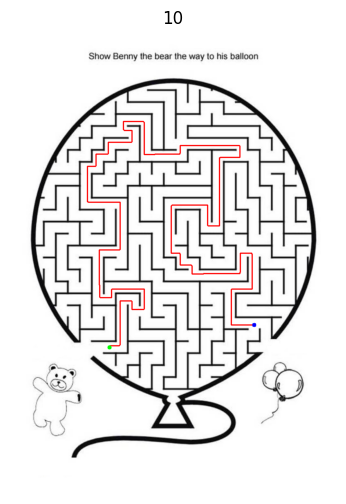

In [37]:

import numpy as np
from collections import deque
import cv2

def bfs_path(binary, start, end):
    """在二值图上用BFS寻找路径"""
    h, w = binary.shape
    dist = np.full((h, w), -1, dtype=np.int32)
    dist[start[0], start[1]] = 0

    parent = {}
    queue = deque([start])
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while queue:
        cy, cx = queue.popleft()
        if (cy, cx) == end:
            break
        for dy, dx in directions:
            ny, nx = cy + dy, cx + dx
            if 0 <= ny < h and 0 <= nx < w:
                if binary[ny, nx] == 255 and dist[ny, nx] == -1:
                    dist[ny, nx] = dist[cy, cx] + 1
                    parent[(ny, nx)] = (cy, cx)
                    queue.append((ny, nx))

    if dist[end[0], end[1]] == -1:
        return None

    path = []
    cur = end
    while cur != start:
        path.append(cur)
        cur = parent[cur]
    path.append(start)
    path.reverse()
    return path


def on_mouse(event, x, y, flags, param):
    global points, display_img, maze_paths
    if event == cv2.EVENT_LBUTTONDOWN:
        if maze_paths[y, x] == 255:
            points.append((y, x))
            cv2.circle(display_img, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow("起点和终点", display_img)
            if len(points) == 1:
                print(f"起点: ({y},{x})")
            elif len(points) == 2:
                print(f"终点: ({y},{x})")
        else:
            print("选择的位置不是通路，请重选")


def main():
    global points, display_img, maze_paths
    wall_margin = 7     # 离墙距离的安全边界（像素数）
    balloon_expand = 40   # 气球外扩的距离（像素数）

    # 读取图像
    image_path = "Puzzle9.png"
    original = cv2.imread(image_path)
    if original is None:
        raise FileNotFoundError("找不到图片")

    # 转灰度并二值化
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # 1. 创建一个空白掩码
    h, w = binary.shape
    balloon_mask = np.zeros((h, w), dtype=np.uint8)

    # 2. 手动绘制气球形状（从图中提取轮廓）
    balloon_center = (w // 2, h // 2)  # 气球中心点
    # 原始半径并外扩 balloon_expand
    balloon_radius = (min(w, h) // 2 - 10) + balloon_expand
    cv2.circle(balloon_mask, balloon_center, balloon_radius, 255, -1)

    # 3. 将气球与迷宫线条叠加
    # 从原始二值图获取迷宫线条（墙壁为黑色）
    maze_walls = cv2.bitwise_not(binary)  # 反转，使墙壁变为白色

    # 加粗墙壁以防止路径穿墙，同时使通路远离墙面
    kernel_size = 2 * wall_margin + 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    thick_walls = cv2.dilate(maze_walls, kernel, iterations=1)

    # 从气球掩码中去除墙壁
    maze_paths = cv2.bitwise_and(balloon_mask, cv2.bitwise_not(thick_walls))

    # 保存处理后的图像以便调试
    cv2.imwrite("debug_balloon_mask.png", balloon_mask)
    cv2.imwrite("debug_maze_walls.png", thick_walls)
    cv2.imwrite("debug_maze_paths.png", maze_paths)

    points = []
    display_img = original.copy()

    cv2.namedWindow("起点和终点", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("起点和终点", 800, 800)
    cv2.setMouseCallback("起点和终点", on_mouse)

    # 显示处理后的掩码，便于选点
    cv2.namedWindow("迷宫通路", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("迷宫通路", 800, 800)
    cv2.imshow("迷宫通路", maze_paths)

    while True:
        cv2.imshow("起点和终点", display_img)
        k = cv2.waitKey(1) & 0xFF
        if k == 27 or len(points) >= 2:
            break

    if len(points) < 2:
        print("未选择足够的点")
        return

    # 寻路
    path = bfs_path(maze_paths, points[0], points[1])

    if path is None:
        print("找不到路径")
    else:
        print(f"找到路径，长度={len(path)}")

        # 在原图上绘制路径
        result = original.copy()
        for i in range(len(path) - 1):
            y1, x1 = path[i]
            y2, x2 = path[i + 1]
            cv2.line(result, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # 标记起点和终点
        cv2.circle(result, (points[0][1], points[0][0]), 5, (0, 255, 0), -1)
        cv2.circle(result, (points[1][1], points[1][0]), 5, (255, 0, 0), -1)

        # 显示结果
        solution_img_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(solution_img_rgb)
        plt.title("10")
        plt.axis('off')
        plt.show()

    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


起点: (746,505)
终点: (585,410)
找到路径，长度=3073


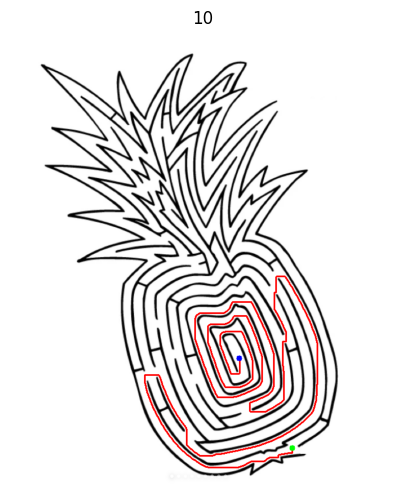

In [41]:

import numpy as np
from collections import deque
import cv2

def bfs_path(binary, start, end):
    """在二值图上用BFS寻找路径"""
    h, w = binary.shape
    dist = np.full((h, w), -1, dtype=np.int32)
    dist[start[0], start[1]] = 0

    parent = {}
    queue = deque([start])
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while queue:
        cy, cx = queue.popleft()
        if (cy, cx) == end:
            break
        for dy, dx in directions:
            ny, nx = cy + dy, cx + dx
            if 0 <= ny < h and 0 <= nx < w:
                if binary[ny, nx] == 255 and dist[ny, nx] == -1:
                    dist[ny, nx] = dist[cy, cx] + 1
                    parent[(ny, nx)] = (cy, cx)
                    queue.append((ny, nx))

    if dist[end[0], end[1]] == -1:
        return None

    path = []
    cur = end
    while cur != start:
        path.append(cur)
        cur = parent[cur]
    path.append(start)
    path.reverse()
    return path


def on_mouse(event, x, y, flags, param):
    global points, display_img, maze_paths
    if event == cv2.EVENT_LBUTTONDOWN:
        # 只允许在迷宫通路上选点
        if maze_paths[y, x] == 255:
            points.append((y, x))
            cv2.circle(display_img, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow("起点和终点", display_img)
            if len(points) == 1:
                print(f"起点: ({y},{x})")
            elif len(points) == 2:
                print(f"终点: ({y},{x})")
        else:
            print("选择的位置不是通路，请重选")


def main():
    global points, display_img, maze_paths
    wall_margin = 2    # 离墙距离的安全边界（像素数）
    balloon_expand = 50   # 气球外扩的距离（像素数）

    # 读取图像
    image_path = "Puzzle10.png"
    original = cv2.imread(image_path)
    if original is None:
        raise FileNotFoundError("找不到图片")

    # 转灰度并二值化
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)


    # 1. 创建一个空白掩码
    h, w = binary.shape
    balloon_mask = np.zeros((h, w), dtype=np.uint8)

    # 2. 手动绘制气球形状（从图中提取轮廓）
    balloon_center = (w // 2, h // 2)  # 气球中心点
    # 原始半径并外扩 balloon_expand
    balloon_radius = (min(w, h) // 2 - 10) + balloon_expand
    cv2.circle(balloon_mask, balloon_center, balloon_radius, 255, -1)

    # 3. 将气球与迷宫线条叠加
    # 从原始二值图获取迷宫线条（墙壁为黑色）
    maze_walls = cv2.bitwise_not(binary)  # 反转，使墙壁变为白色

    # 加粗墙壁以防止路径穿墙，同时使通路远离墙面
    kernel_size = 2 * wall_margin + 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    thick_walls = cv2.dilate(maze_walls, kernel, iterations=1)

    # 从气球掩码中去除墙壁
    maze_paths = cv2.bitwise_and(balloon_mask, cv2.bitwise_not(thick_walls))

    # 保存处理后的图像以便调试
    cv2.imwrite("debug_balloon_mask.png", balloon_mask)
    cv2.imwrite("debug_maze_walls.png", thick_walls)
    cv2.imwrite("debug_maze_paths.png", maze_paths)

    points = []
    display_img = original.copy()

    cv2.namedWindow("起点和终点", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("起点和终点", 800, 800)
    cv2.setMouseCallback("起点和终点", on_mouse)

    # 显示处理后的掩码，便于选点
    cv2.namedWindow("迷宫通路", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("迷宫通路", 800, 800)
    cv2.imshow("迷宫通路", maze_paths)

    while True:
        cv2.imshow("起点和终点", display_img)
        k = cv2.waitKey(1) & 0xFF
        if k == 27 or len(points) >= 2:
            break

    if len(points) < 2:
        print("未选择足够的点")
        return

    # 寻路
    path = bfs_path(maze_paths, points[0], points[1])

    if path is None:
        print("找不到路径")
    else:
        print(f"找到路径，长度={len(path)}")

        # 在原图上绘制路径
        result = original.copy()
        for i in range(len(path) - 1):
            y1, x1 = path[i]
            y2, x2 = path[i + 1]
            cv2.line(result, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # 标记起点和终点
        cv2.circle(result, (points[0][1], points[0][0]), 5, (0, 255, 0), -1)
        cv2.circle(result, (points[1][1], points[1][0]), 5, (255, 0, 0), -1)

        # 显示结果
        solution_img_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(solution_img_rgb)
        plt.title("10")
        plt.axis('off')
        plt.show()

    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


起点: (91,571)
终点: (565,538)
找到路径，长度=2540


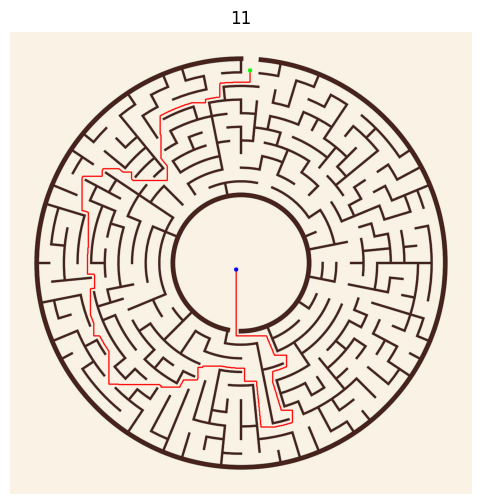

In [46]:

import numpy as np
from collections import deque
import cv2

def bfs_path(binary, start, end):
    """在二值图上用BFS寻找路径"""
    h, w = binary.shape
    dist = np.full((h, w), -1, dtype=np.int32)
    dist[start[0], start[1]] = 0

    parent = {}
    queue = deque([start])
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while queue:
        cy, cx = queue.popleft()
        if (cy, cx) == end:
            break
        for dy, dx in directions:
            ny, nx = cy + dy, cx + dx
            if 0 <= ny < h and 0 <= nx < w:
                if binary[ny, nx] == 255 and dist[ny, nx] == -1:
                    dist[ny, nx] = dist[cy, cx] + 1
                    parent[(ny, nx)] = (cy, cx)
                    queue.append((ny, nx))

    if dist[end[0], end[1]] == -1:
        return None

    path = []
    cur = end
    while cur != start:
        path.append(cur)
        cur = parent[cur]
    path.append(start)
    path.reverse()
    return path


def on_mouse(event, x, y, flags, param):
    global points, display_img, maze_paths
    if event == cv2.EVENT_LBUTTONDOWN:
        if maze_paths[y, x] == 255:
            points.append((y, x))
            cv2.circle(display_img, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow("起点和终点", display_img)
            if len(points) == 1:
                print(f"起点: ({y},{x})")
            elif len(points) == 2:
                print(f"终点: ({y},{x})")
        else:
            print("选择的位置不是通路，请重选")


def main():
    global points, display_img, maze_paths
    wall_margin = 5    # 离墙距离的安全边界（像素数）
    balloon_expand = 50   # 气球外扩的距离（像素数）

    # 读取图像
    image_path = "PuzzleNotWork1.png"
    original = cv2.imread(image_path)
    if original is None:
        raise FileNotFoundError("找不到图片")

    # 转灰度并二值化
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    # 1. 创建一个空白掩码
    h, w = binary.shape
    balloon_mask = np.zeros((h, w), dtype=np.uint8)

    # 2. 手动绘制气球形状（从图中提取轮廓）
    balloon_center = (w // 2, h // 2)  # 气球中心点
    # 原始半径并外扩 balloon_expand
    balloon_radius = (min(w, h) // 2 - 10) + balloon_expand
    cv2.circle(balloon_mask, balloon_center, balloon_radius, 255, -1)

    # 3. 将气球与迷宫线条叠加
    # 从原始二值图获取迷宫线条（墙壁为黑色）
    maze_walls = cv2.bitwise_not(binary)  # 反转，使墙壁变为白色

    # 加粗墙壁以防止路径穿墙，同时使通路远离墙面
    kernel_size = 2 * wall_margin + 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    thick_walls = cv2.dilate(maze_walls, kernel, iterations=1)

    # 从气球掩码中去除墙壁
    maze_paths = cv2.bitwise_and(balloon_mask, cv2.bitwise_not(thick_walls))

    # 保存处理后的图像以便调试
    cv2.imwrite("debug_balloon_mask.png", balloon_mask)
    cv2.imwrite("debug_maze_walls.png", thick_walls)
    cv2.imwrite("debug_maze_paths.png", maze_paths)

    # 交互式选择起点和终点
    points = []
    display_img = original.copy()

    cv2.namedWindow("起点和终点", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("起点和终点", 800, 800)
    cv2.setMouseCallback("起点和终点", on_mouse)

    # 显示处理后的掩码，便于选点
    cv2.namedWindow("迷宫通路", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("迷宫通路", 800, 800)
    cv2.imshow("迷宫通路", maze_paths)

    while True:
        cv2.imshow("起点和终点", display_img)
        k = cv2.waitKey(1) & 0xFF
        if k == 27 or len(points) >= 2:
            break

    if len(points) < 2:
        print("未选择足够的点")
        return

    # 寻路
    path = bfs_path(maze_paths, points[0], points[1])

    if path is None:
        print("找不到路径")
    else:
        print(f"找到路径，长度={len(path)}")

        # 在原图上绘制路径
        result = original.copy()
        for i in range(len(path) - 1):
            y1, x1 = path[i]
            y2, x2 = path[i + 1]
            cv2.line(result, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # 标记起点和终点
        cv2.circle(result, (points[0][1], points[0][0]), 5, (0, 255, 0), -1)
        cv2.circle(result, (points[1][1], points[1][0]), 5, (255, 0, 0), -1)

        # 显示结果
        solution_img_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(solution_img_rgb)
        plt.title("11")
        plt.axis('off')
        plt.show()

    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


起点: (44,379)
终点: (388,375)
找到路径，长度=8003


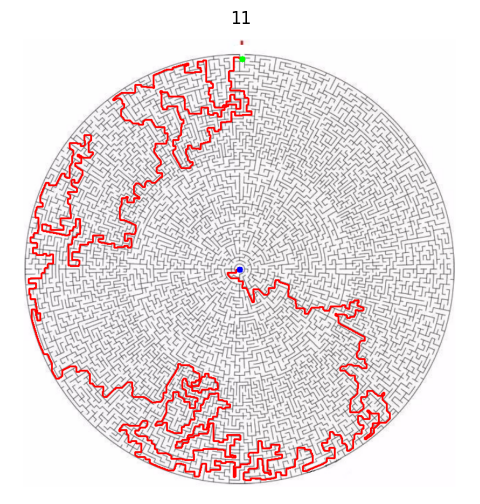

In [45]:

import numpy as np
from collections import deque
import cv2

def bfs_path(binary, start, end):
    """在二值图上用BFS寻找路径"""
    h, w = binary.shape
    dist = np.full((h, w), -1, dtype=np.int32)
    dist[start[0], start[1]] = 0

    parent = {}
    queue = deque([start])
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while queue:
        cy, cx = queue.popleft()
        if (cy, cx) == end:
            break
        for dy, dx in directions:
            ny, nx = cy + dy, cx + dx
            if 0 <= ny < h and 0 <= nx < w:
                if binary[ny, nx] == 255 and dist[ny, nx] == -1:
                    dist[ny, nx] = dist[cy, cx] + 1
                    parent[(ny, nx)] = (cy, cx)
                    queue.append((ny, nx))

    if dist[end[0], end[1]] == -1:
        return None

    path = []
    cur = end
    while cur != start:
        path.append(cur)
        cur = parent[cur]
    path.append(start)
    path.reverse()
    return path


def on_mouse(event, x, y, flags, param):
    global points, display_img, maze_paths
    if event == cv2.EVENT_LBUTTONDOWN:
        if maze_paths[y, x] == 255:
            points.append((y, x))
            cv2.circle(display_img, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow("起点和终点", display_img)
            if len(points) == 1:
                print(f"起点: ({y},{x})")
            elif len(points) == 2:
                print(f"终点: ({y},{x})")
        else:
            print("选择的位置不是通路，请重选")


def main():
    global points, display_img, maze_paths
    wall_margin = 0    # 离墙距离的安全边界（像素数）
    balloon_expand = 50   # 气球外扩的距离（像素数）

    # 读取图像
    image_path = "PuzzleNotWork2.png"
    original = cv2.imread(image_path)
    if original is None:
        raise FileNotFoundError("找不到图片")

    # 转灰度并二值化
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    # 1. 创建一个空白掩码
    h, w = binary.shape
    balloon_mask = np.zeros((h, w), dtype=np.uint8)

    # 2. 手动绘制气球形状（从图中提取轮廓）
    balloon_center = (w // 2, h // 2)  # 气球中心点
    # 原始半径并外扩 balloon_expand
    balloon_radius = (min(w, h) // 2 - 10) + balloon_expand
    cv2.circle(balloon_mask, balloon_center, balloon_radius, 255, -1)

    # 3. 将气球与迷宫线条叠加
    # 从原始二值图获取迷宫线条（墙壁为黑色）
    maze_walls = cv2.bitwise_not(binary)  # 反转，使墙壁变为白色

    # 加粗墙壁以防止路径穿墙，同时使通路远离墙面
    kernel_size = 2 * wall_margin + 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    thick_walls = cv2.dilate(maze_walls, kernel, iterations=1)

    # 从气球掩码中去除墙壁
    maze_paths = cv2.bitwise_and(balloon_mask, cv2.bitwise_not(thick_walls))

    # 保存处理后的图像以便调试
    cv2.imwrite("debug_balloon_mask.png", balloon_mask)
    cv2.imwrite("debug_maze_walls.png", thick_walls)
    cv2.imwrite("debug_maze_paths.png", maze_paths)

    # 交互式选择起点和终点
    points = []
    display_img = original.copy()

    cv2.namedWindow("起点和终点", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("起点和终点", 800, 800)
    cv2.setMouseCallback("起点和终点", on_mouse)

    # 显示处理后的掩码，便于选点
    cv2.namedWindow("迷宫通路", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("迷宫通路", 800, 800)
    cv2.imshow("迷宫通路", maze_paths)

    while True:
        cv2.imshow("起点和终点", display_img)
        k = cv2.waitKey(1) & 0xFF
        if k == 27 or len(points) >= 2:
            break

    if len(points) < 2:
        print("未选择足够的点")
        return

    # 寻路
    path = bfs_path(maze_paths, points[0], points[1])

    if path is None:
        print("找不到路径")
    else:
        print(f"找到路径，长度={len(path)}")

        # 在原图上绘制路径
        result = original.copy()
        for i in range(len(path) - 1):
            y1, x1 = path[i]
            y2, x2 = path[i + 1]
            cv2.line(result, (x1, y1), (x2, y2), (0, 0, 255), 2)

        # 标记起点和终点
        cv2.circle(result, (points[0][1], points[0][0]), 5, (0, 255, 0), -1)
        cv2.circle(result, (points[1][1], points[1][0]), 5, (255, 0, 0), -1)

        # 显示结果
        solution_img_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(solution_img_rgb)
        plt.title("11")
        plt.axis('off')
        plt.show()

    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()
